In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import os

import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import nibabel as nib
import matplotlib.pyplot as plt

2.8.0


Change paths to run script 

In [ ]:
#NFBS Dataset contains 125 subject having - 1. T1w MRI, 2. T1w Brain(skull stripped) and 3. Brain Mask

#Training and Validation Dataset for Skull Stripping
nfbs_dataset_path = '/content/drive/MyDrive/bsai/NFBS_Dataset'

#Paths to access the T1w, brain and brainmask scan of any subject of training and validation dataset
sub_path = ('/sub-')
t1w_filepath = '_ses-NFB3_T1w.nii.gz' 
t1w_brain_filepath= '_ses-NFB3_T1w_brain.nii.gz'
brainmask_filepath= '_ses-NFB3_T1w_brainmask.nii.gz'


#Testing Dataset 
test_dataset_path = '/content/drive/MyDrive/bsai/T1Img'

#Trained model path
model_path = '/content/drive/MyDrive/bsai/model/m2.hdf5'


# Preprocessing Dataset

####Reading data and Preprocessing

####Preprocessing steps-
#####1.Changing image to axial view.
#####2.Cropping image to remove extra background (256,256,192) to (128,160,160).
#####3.Normalizing T1w MRI to have zero mean and unit standard deviation.

In [ ]:
def get_sub_list():
  
  #Get Subject IDs
  sub_list = []
  for sub in os.listdir(nfbs_dataset_path):
    sub_list.append(sub)

  return sub_list


def normalize_image(array_img):
  #Normalize image to zero mean and unit variance
  image_nonzero = array_img[np.nonzero(array_img)]
  if np.std(array_img)==0 or np.std(image_nonzero) == 0:
    return array_img
  else:
    normalized_img = (array_img - np.mean(image_nonzero)) / np.std(image_nonzero)
    return normalized_img


def load_file(sub,filepath, normalize=False):

  #Reading nifty file to get image array
  filename = nfbs_dataset_path+'/'+sub+ sub_path +sub + filepath
  nifti_file = nib.load(filename)
  array_img = nifti_file.get_fdata()
  
  #Change image to axial view
  array_img = np.moveaxis(array_img, 0, 1)

  #Cropping image to remove extra background (256,256,192) to (128,160,160)
  array_img = array_img[32:160,66:226,16:176] 

  #Normalize image to zero mean and unit variance (for T1w only)
  if normalize==True:
    array_img = normalize_image(array_img) 

  #reshape array for batch=1 and channel=1 (128,160,160) to (1,128,160,160,1)
  array_img = array_img.reshape((1,array_img.shape[0],array_img.shape[1],array_img.shape[2],1))

  return array_img


def get_t1w(sub, normalize=True):
  return load_file(sub,t1w_filepath, normalize)

def get_brain(sub):
  return load_file(sub,t1w_brain_filepath)

def get_mask(sub):
  return load_file(sub,brainmask_filepath)


def load_test_file(i=1):

  
  # i denotes subject number (default = 1)
  
  try:
    filename = test_dataset_path+'/sub-0'+str(i)+'/T1w.nii.gz'
    nifti_file = nib.load(filename)
  except:
    filename = test_dataset_path+'/sub-0'+str(i)+'/T1w.nii'
    nifti_file = nib.load(filename)
  #array_img = nifti_file.get_fdata()
  #array_img = array_img.reshape((1,array_img.shape[0],array_img.shape[1],array_img.shape[2],1))
  return nifti_file






####Visualize Training Data

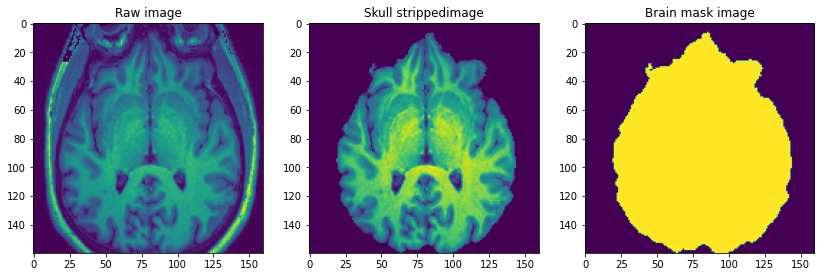

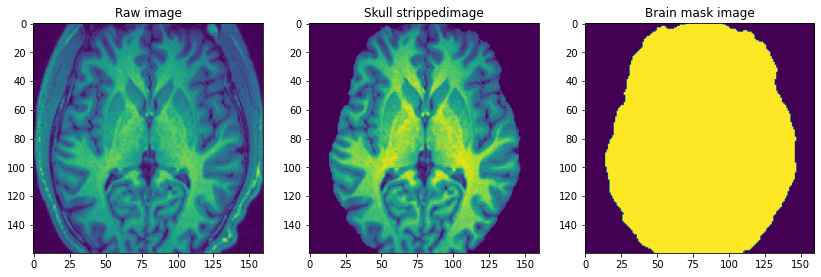

In [ ]:
def visualize_training_data(slice_num = 32):
  
  sub_list = get_sub_list()

  for i in range(2):

    image_shape = (256,256,192)
    slice_number = 32

    fig,ax=plt.subplots(1,3,figsize=(14,10))
    ax[0].set_title('Raw image')
    img = get_t1w(sub_list[i])
    ax[0].imshow(img[0,slice_num,:,:,0])

    ax[1].set_title('Skull strippedimage')
    img = get_brain(sub_list[i])
    ax[1].imshow(img[0,slice_num,:,:,0])

    ax[2].set_title('Brain mask image')
    img = get_mask(sub_list[i])
    ax[2].imshow(img[0,slice_num,:,:,0])

    #print(dice(img,img))


visualize_training_data(64)

####Data Generators-
#####For training time data augmentation, implemented custom 3D data generator on top of keras.utils.Sequence.
#####Applied random axis flip with probability 0.5 in last axes. Then applied random intensity shift to each channel in the range of -0.1 to 0.1. And then random scaling (in between 0.9 to 1.1) is done on them. 
#####This helps us in regularization and avoiding overfitting of model and, overcoming the problem of small dataset.

#####No augmenatation on validation data.

In [ ]:
# Function for training time data augmentation

#Flip image according to the given axis
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


#Intensity shift 
def apply_intensity_shift(x, intensity, channel_axis=2):
   
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [
        np.clip(x_channel + intensity,
                min_x,
                max_x)
        for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

#Random intensity shift
def random_intensity_shift(x, intensity_range,depth_axis=0, channel_axis=3):
    
    d = x.shape[depth_axis]
    intensity = np.random.uniform(-intensity_range, intensity_range)
    for i in range(d):
        x[i,] =  apply_intensity_shift(x[i], intensity)
    return x

In [ ]:
class TrainDataGen(tf.keras.utils.Sequence):

  def __init__(self, sub_list = [], batch_size=1, shuffle=True):
    
    self.batch_size = batch_size
    self.shuffle = shuffle

    self.sub_list = sub_list
    self.length = len(sub_list)
    self.on_epoch_end()


  def __len__(self):
    return int(np.ceil(self.length/self.batch_size))


  def __getitem__(self, index):
    
    #Loading data
    t1w = get_t1w(self.sub_list[index])
    mask = get_mask(self.sub_list[index])
    
    #Data augmentation
    t1w[0,], mask[0] = self.random_transform(t1w, mask) 

    return t1w, mask


  def on_epoch_end(self):
    #Reshuffle subjects after each epoch
    if self.shuffle == True:
      np.random.shuffle(self.sub_list)

  

  def random_transform(self,x,y):

    if (np.random.random() < 0.5):
      x = flip_axis(x,2)
      y = flip_axis(y,2)
    

    if (np.random.random() < 0.5):
      x = random_intensity_shift(x,0.1)
    if (np.random.random() < 0.5):
      rescale = np.random.uniform(0.9, 1.1)
      x *= rescale
    
    return x, y




In [ ]:
class ValDataGen(tf.keras.utils.Sequence):

  def __init__(self, sub_list = [], batch_size=1, shuffle=True):
    
    self.batch_size = batch_size
    self.shuffle = shuffle

    self.sub_list = sub_list
    self.length = len(sub_list)


  def __len__(self):
    return int(np.ceil(self.length/self.batch_size))


  def __getitem__(self, index):
    
    t1w = get_t1w(self.sub_list[index])
    mask = get_mask(self.sub_list[index])

    t1w[0,], mask[0] = t1w, mask

    return t1w, mask


####Model Design and Architecture

######Asymmetric encoder-decoder based architecture using 3D CNN, smallest size kernel 3 x 3 x 3, using GroupNormalization (performs better than BatchNormalization incase of less number of batch_size) and LeakyReLU as activation function. input_shape = (128,160,160,1), using largest input patch size possible.

######Conv Block-
Each convolution block contains - (3DConv-GroupNormalization-LeakyReLU)  

######Encoder-

*   Three conv block with middle one having stride=2 for downsizing.
*   Started with a convolution block which has 32 number of filters with no downsizing. Then downsizing image dimension by 2 using conv strides and simultaneously doubling the number of features. Then conv block with no downsizing. All convolutions are 3 x 3 x 3. 

######Decoder-

*   Upsampling using Conv3DTranspose.
*   Addition with output from the encoder of the equivalent spatial level (skip connections)

######Output-
Conv layer with sigmoid as activation function

Because of the hardware limitations, more complex/deeper model could not be used.

In [ ]:
def conv_block(inp, filters, strides=1, name=None):
    
  x = tf.keras.layers.Conv3D(
      filters=filters,
      kernel_size=(3, 3, 3),
      strides=strides,
      padding='same',
      data_format='channels_last',
      name=name)(inp)

  x = tfa.layers.GroupNormalization()(x)
  x = tf.keras.layers.LeakyReLU()(x)

  return x

def transpose(inp, filters, name=None):

  x = tf.keras.layers.Conv3DTranspose(
      filters=filters,
      kernel_size=(3, 3, 3),
      strides=(2, 2, 2),
      padding='same',
      data_format='channels_last',
      name=name)(inp)

  return x



In [ ]:
def AutoEncoderModel(input_shape = (128,160,160,1)):
    
  inputs = tf.keras.Input(input_shape)

  #ENCODER
  x1 = conv_block(inputs, filters=32, name='enc_conv_1_1')
  #x1 = conv_block(x, filters=32, name='enc_conv_1_2')

  x = conv_block(x1, filters=64, strides=2, name='enc_conv_2_1')
  x2 = conv_block(x, filters=64, name='enc_conv_2_2')

  #x = conv_block(x2, filters=128, strides=2, name='enc_conv_3_1')
  #x = conv_block(x, filters=128, name='enc_conv_3_2')

  #DECODER
  #x = transpose(x, filters=64, name='dec_tconv_2_1')
  #x = tf.keras.layers.Add()([x,x2])
  #x = conv_block(x, filters=64, name='dec_conv_2_2')

  x = transpose(x2, filters=32, name='dec_tconv_1_1')
  x = tf.keras.layers.Add()([x,x1])
  #x = conv_block(x, filters=32, name='dec_conv_1_2')

  outputs = tf.keras.layers.Conv3D(1, 1, activation='sigmoid', padding='same', data_format = 'channels_last', name='output')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = AutoEncoderModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 160, 1  0           []                               
                                60, 1)]                                                           
                                                                                                  
 enc_conv_1_1 (Conv3D)          (None, 128, 160, 16  896         ['input_1[0][0]']                
                                0, 32)                                                            
                                                                                                  
 group_normalization (GroupNorm  (None, 128, 160, 16  64         ['enc_conv_1_1[0][0]']           
 alization)                     0, 32)                                                        

####Training

*   Optimizer: SGD with learning_rate=0.01, momentum=0.99
*   Loss: Soft Dice Loss
*   Metrices: Dice Coefficient
*   Batch size: We are using batch size of 1, and each input patch is drawn once in an epoch and in random order.
*   Hardware Configuration: Trained on Google colab TPU








Dice Coefficient Metric and Loss Function for Model Training

In [ ]:
import keras.backend as K

def dice(y_true, y_pred,e=1e-8):
    #computes the dice score on two tensors

  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
  dice_score = (2. * intersection) / (K.sum(y_true_f, -1) + K.sum(y_pred_f, -1) + e)

  return dice_score

def soft_dice_loss(y_true, y_pred,e=1e-8):

  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
  loss_dice = (2. * intersection) / (K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + e)

  return 1-loss_dice

Train Validation Split of 125 subjects (110 training and 15 validation)

In [ ]:
def data_split():
  #Total 125 subjects in dataset
  sub_list = get_sub_list()

  #For training 110 subjects
  train_sub_list = sub_list[:110]
  training_data_gen = TrainDataGen(train_sub_list) #Data Generator

  #For validation 15 subjects
  validation_sub_list = sub_list[110:]
  validation_data_gen = ValDataGen(validation_sub_list)#Data Generator

  return training_data_gen, validation_data_gen

In [ ]:
def train_model():

  #optimizer
  sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.99)
  
  #create model
  model = AutoEncoderModel()
  model.compile(optimizer=sgd_optimizer, loss=soft_dice_loss, metrics=['accuracy',dice])

  #Train validation split
  training_data_gen, validation_data_gen = data_split()
  
  #checkpointer to save best model
  check_pointer = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/bsai/model/model1_.{epoch:03d}_{loss:.3f}', verbose=1,monitor='loss',  save_best_only=True,mode='auto',)
  
  #train
  model.fit(training_data_gen, validation_data =validation_data_gen, epochs=100, callbacks=[check_pointer])

  return model


Uncomment the cell to start train 

In [ ]:
#model = train_model()

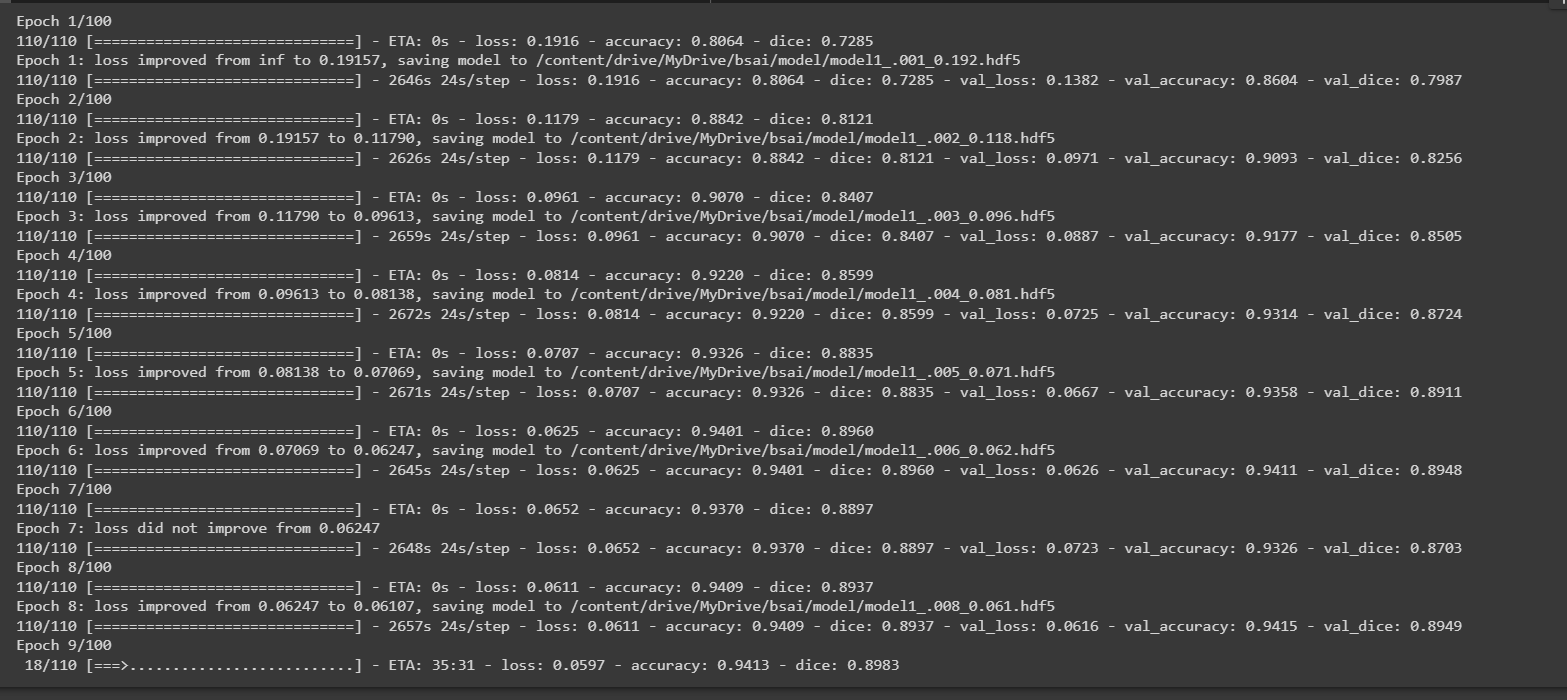


Due to resources limitation, used lesser deep model. 

At the end of epoch 8 : 
Both Training and validation dice coefficient is around 0.89

Training Time per epoch ~ 55 min


Training was started for 100 epochs, but
due to Colab time restrictions, notebook disconnects and training stops midway.
Thatswhy, model saved after epoch-8 is used for prediction.
 
Further training could be done later.


##Inference-
End to end pipeline gives brain mri as output (nifti format), while keeping all header values of orfiginal t1w file

In [ ]:
#End to end pipeline for skull stripping inference
#Input - index of subject
# Reads nifti file, predict mask using model, post process mask, then get brain t1w in nifti format
#Output - Brain T1w (skull stripped) nifti file
def predict(index, model, slice_num=82):
  
  sub_list = get_sub_list()

  #Reading original t1w nifty file
  filename = nfbs_dataset_path+'/'+sub_list[index]+ sub_path +sub_list[index] + t1w_filepath
  nifti_file = nib.load(filename)
  array_img = nifti_file.get_fdata()
  header = nifti_file.header
  affine = nifti_file.affine

  #Loading preprocessed data
  t1w = get_t1w(sub_list[index])
  mask = get_mask(sub_list[index])

  #POST PROCESSING
  #Predicting mask of MRI using trained model
  predicted_mask = model.predict(t1w)
  #Post-processing the mask
  mri_mask = np.where(predicted_mask<0.5, 0.0, 1.0)
  #Adding cropped area (128,160,160) to (256,256,192)
  y = np.zeros((256,256,192), dtype=np.float32)
  y[32:160,66:226,16:176] = mri_mask[0,:,:,:,0]
  #Change image to original view
  y = np.moveaxis(y, 1, 0)

  #Getting only brain MRI
  mri_brain = np.where(y==1.0, array_img, array_img.min())

  #Getting brain (skull stripped) nifti file
  t1w_brain = nib.Nifti1Image(mri_brain, affine=affine, header=header)

  dice_value = np.array(dice(mask, mri_mask))
  print('Dice coefficient value: ', dice_value)

  fig,ax=plt.subplots(1,3,figsize=(14,10))
  ax[0].imshow(array_img[:,slice_num,:])
  ax[0].set_title('T1w MRI ')
  ax[1].imshow(y[:,slice_num,:])
  ax[1].set_title('Brain Mask ')
  ax[2].imshow(mri_brain[:,slice_num,:])
  ax[2].set_title('T1w Brain ')

  return t1w_brain, dice_value  
  


Dice coefficient value:  0.9157345746196488
Dice coefficient value:  0.92543133415617


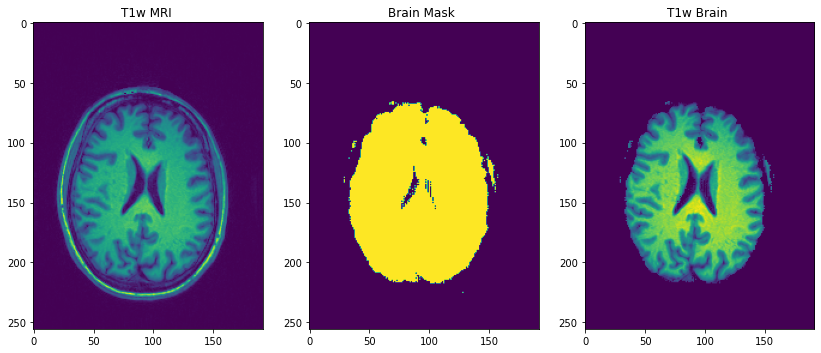

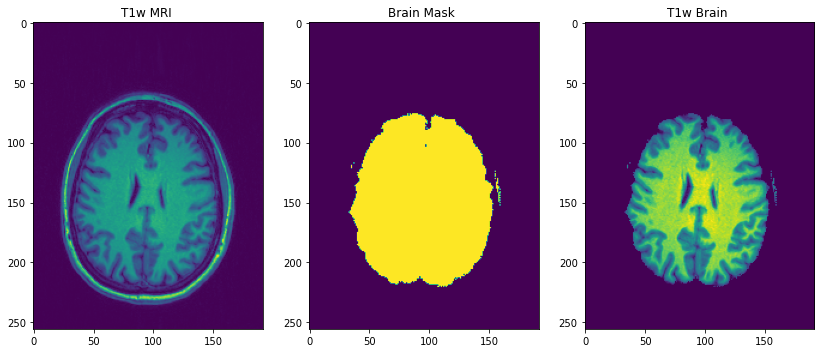

In [ ]:
#Load Trained Model
prediction_model = tf.keras.models.load_model(model_path ,custom_objects ={'soft_dice_loss':soft_dice_loss, 'dice':dice})

#Prediction on few test subjects
t1w_brain, dice_value = predict(110, prediction_model)
t1w_brain, dice_value = predict(112, prediction_model)

Dice coefficient value:  0.9244565711507071
Dice coefficient value:  0.9339789879721313


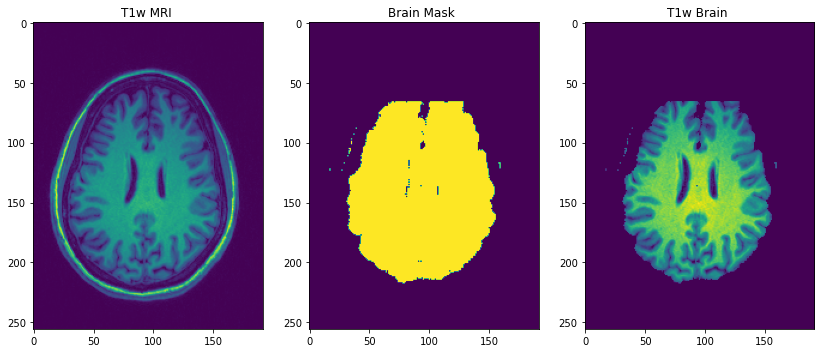

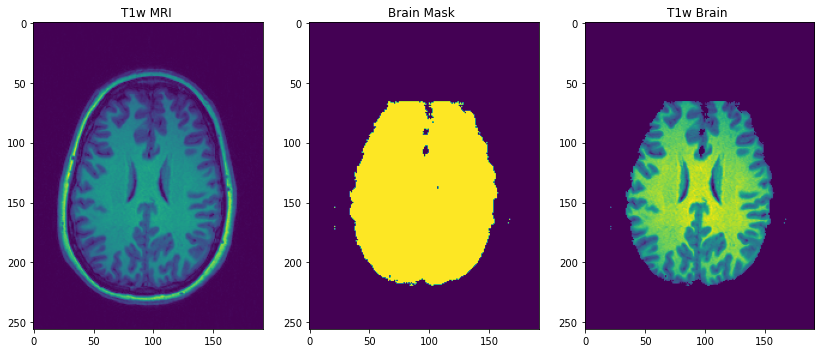

In [ ]:
t1w_brain, dice_value = predict(120, prediction_model)
t1w_brain, dice_value = predict(124, prediction_model)

Dice coefficient value:  0.8990461843952977
Dice coefficient value:  0.9371907809183714


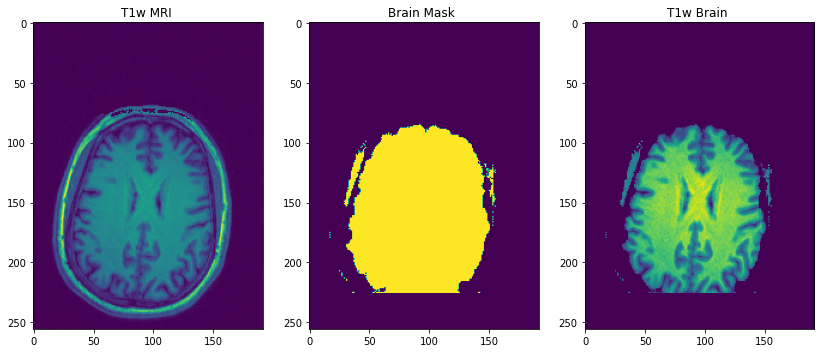

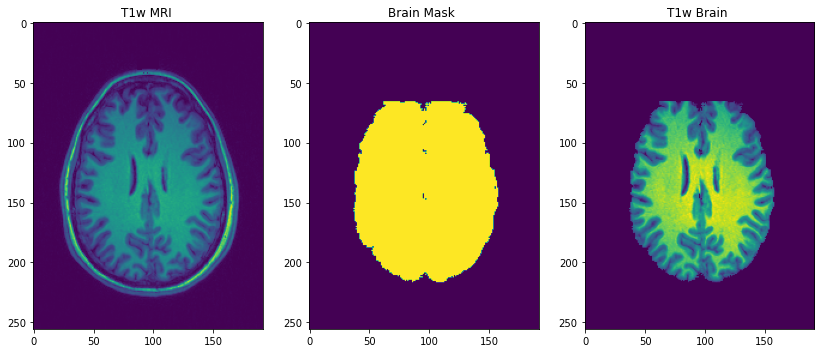

In [ ]:
t1w_brain, dice_value = predict(115, prediction_model)
t1w_brain, dice_value = predict(118, prediction_model)

In [ ]:

def predict_test(mri_t1w, model, slice_num=16):

  mri_test = mri_t1w.get_fdata()

  #Pre-processing and resizing the image 
  mri_test = np.moveaxis(mri_test, 0, 2)
  mri_test = np.moveaxis(mri_test, 0, 1)
  mri_test = np.fliplr(mri_test)
  mri_test = np.flipud(mri_test)
  mri_test = mri_test[32:160,66:226,:]

  mri_test_input = mri_test.reshape(1,128,160,160,1)

  #Predicting mask of MRI using trained model
  predicted_mask = model.predict(mri_test_input)
  predicted_mask = predicted_mask.reshape(128,160,160)

  #Post-processing the mask
  mri_mask = np.where(predicted_mask<0.5, 0.0, 1.0)

  #Getting only brain MRI
  mri_brain= np.where(predicted_mask<0.5, 1.0, mri_test)

  for i in range(4):
    
    slice_num = slice_num + 16
    #print(slice_num)
    fig,ax=plt.subplots(1,4,figsize=(14,10))
    ax[0].imshow(mri_test[slice_num])
    ax[0].set_title('T1w MRI ')
    ax[1].imshow(predicted_mask[slice_num])
    ax[1].set_title('Predicted Mask')
    ax[2].imshow(mri_mask[slice_num])
    ax[2].set_title('After Post processing')
    ax[3].imshow(mri_brain[slice_num])
    ax[3].set_title('T1w brain')



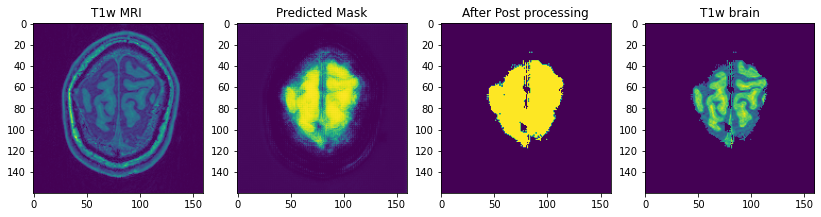

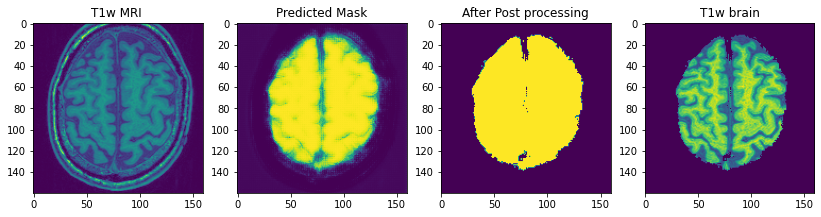

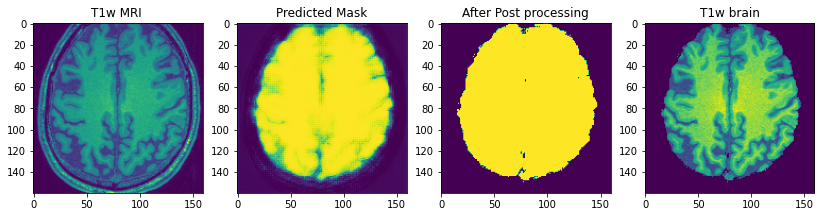

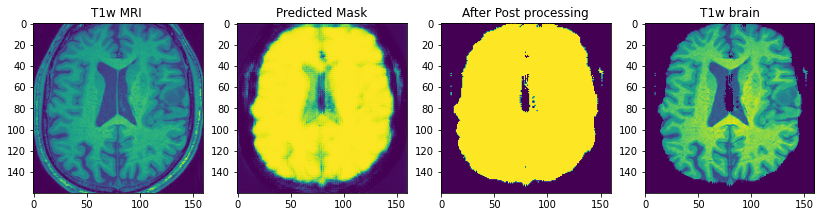

In [ ]:
#Load Trained Model
prediction_model = tf.keras.models.load_model(model_path ,custom_objects ={'soft_dice_loss':soft_dice_loss, 'dice':dice})

# Reading T1w MRI of Brainsight data sub_01
mri_t1w = load_test_file()

#Prediction
predict_test(mri_t1w, prediction_model)